In [3]:
import numpy as np
import matplotlib.pyplot as plt
 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from pytorchsummary import summary

torch.use_deterministic_algorithms(True)

In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat Feb 22 2025

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

matplotlib : 3.9.0
torchvision: 0.18.0
numpy      : 1.26.4
torch      : 2.3.0

Watermark: 2.4.3



In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 3 input image channel, 6 output feature maps and 5x5 conv kernel
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
        # 6 input image channel, 16 output feature maps and 5x5 conv kernel
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        # fully connected layers of size 120, 84 and 10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 is the spatial dimension at this layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        # Flatten spatial and depth dimensions into a single vector
        #x = torch.flatten(x, 1)
        x = x.view(-1, self.flattened_features(x))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x # F.log_softmax(x, dim=1)
    
    def flattened_features(self, x):
        # all except the first (batch) dimension
        size = x.size()[1:]  
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats
    
lenet = LeNet()
print(summary((3,32,32), lenet))

               Layer	Output Shape        	    Kernal Shape    	#params             	#(weights + bias)   	requires_grad
------------------------------------------------------------------------------------------------------------------------------------------------------
            Conv2d-1	[1, 6, 28, 28]      	    [6, 3, 5, 5]    	456                 	(450 + 6)           	True True 
              ReLU-2	[1, 6, 28, 28]      	                    	                    	                    	          
         MaxPool2d-3	[1, 6, 14, 14]      	                    	                    	                    	          
            Conv2d-4	[1, 16, 10, 10]     	   [16, 6, 5, 5]    	2416                	(2400 + 16)         	True True 
              ReLU-5	[1, 16, 10, 10]     	                    	                    	                    	          
         MaxPool2d-6	[1, 16, 5, 5]       	                    	                    	                    	          
            Linear-7	[1, 120]     

In [ ]:
def train(net, trainloader, optim, epoch):
    # initialize loss
    loss_total = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # ip refers to the input images, and ground_truth refers to the output classes the images belong to
        ip, ground_truth = data

        # zero the parameter gradients
        optim.zero_grad()

        # forward pass + backward pass + optimization step
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth) # wants logits, not softmax
        loss.backward()
        optim.step()

        # update loss
        loss_total += loss.item()
        
        # print loss statistics
        if (i+1) % 1000 == 0:    # print at the interval of 1000 mini-batches
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 1000))
            loss_total = 0.0

In [7]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    print('LeNet accuracy on 10000 images from test dataset: %d %%' % (
        100 * success / counter))

In [8]:
# The mean and std are kept as 0.5 for normalizing pixel values as the pixel values are originally in the range 0 to 1
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)


test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)


# ordering is important
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


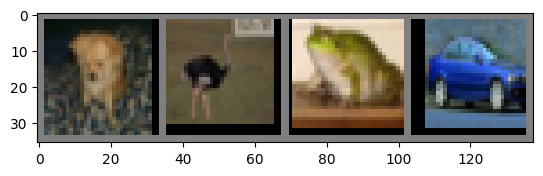

    dog  ||  bird  ||  frog  ||  car


In [9]:
# define a function that displays an image
def imageshow(image):
    # un-normalize the image
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()


# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)

# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

In [10]:
# define optimizer
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

# training loop over the dataset multiple times
for epoch in range(50):  
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 9.795
[Epoch number : 1, Mini-batches:  2000] loss: 8.844
[Epoch number : 1, Mini-batches:  3000] loss: 8.318
[Epoch number : 1, Mini-batches:  4000] loss: 8.132
[Epoch number : 1, Mini-batches:  5000] loss: 7.897
[Epoch number : 1, Mini-batches:  6000] loss: 7.720

LeNet accuracy on 10000 images from test dataset: 49 %

[Epoch number : 2, Mini-batches:  1000] loss: 7.516
[Epoch number : 2, Mini-batches:  2000] loss: 7.428
[Epoch number : 2, Mini-batches:  3000] loss: 7.365
[Epoch number : 2, Mini-batches:  4000] loss: 7.276
[Epoch number : 2, Mini-batches:  5000] loss: 7.214
[Epoch number : 2, Mini-batches:  6000] loss: 7.146

LeNet accuracy on 10000 images from test dataset: 52 %

[Epoch number : 3, Mini-batches:  1000] loss: 7.025
[Epoch number : 3, Mini-batches:  2000] loss: 6.939
[Epoch number : 3, Mini-batches:  3000] loss: 6.911
[Epoch number : 3, Mini-batches:  4000] loss: 6.752
[Epoch number : 3, Mini-batches:  5000] loss: 6.830
[E

In [11]:
model_path = './cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

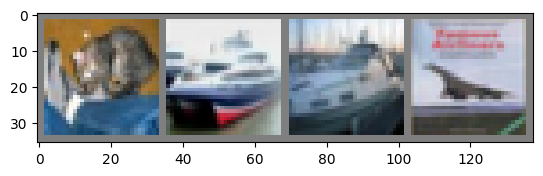

Label:         cat  ship  ship plane
Prediction:    cat  ship  ship plane


In [12]:
# load test dataset images
d_iter = iter(testloader)
im, ground_truth = next(d_iter)

# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# load model
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

# model inference
op = lenet_cached(im)

# print predictions
_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

In [13]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 10000 images from test dataset: %d %%' % (
    100 * success / counter))

Model accuracy on 10000 images from test dataset: 67 %


In [14]:
class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(10000):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1


for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class plane : 73 %
Model accuracy for class   car : 85 %
Model accuracy for class  bird : 45 %
Model accuracy for class   cat : 44 %
Model accuracy for class  deer : 59 %
Model accuracy for class   dog : 54 %
Model accuracy for class  frog : 85 %
Model accuracy for class horse : 77 %
Model accuracy for class  ship : 83 %
Model accuracy for class truck : 70 %
